# Windowing Diagrams

## Rectangular Window

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

In [2]:
def delta_funcs(x, h=1, xmin=None, xmax=None):
    """
    Return arrays for plotting delta functions
    at locations x with heights h
    """
    if xmin is None:
        xmin = min(x) - 1
    if xmax is None:
        xmax = max(x) + 1
    dx = 0.002 * (xmax - xmin)
    def vals():
        yield (xmin, 0)
        for xi, hi in sorted(np.broadcast(x, h)):
            yield from zip([xi - dx, xi, xi + dx], [0, hi, 0])
        yield (xmax, 0)
    return zip(*vals())


def tophat_func(width, height=None, center=0, xmin=None, xmax=None):
    """
    Return arrays for plotting a tophat function
    """
    if xmin is None:
        xmin = min(x) - 1
    if xmax is None:
        xmax = max(x) + 1
    if height is None:
        height = 1. / width
    left = center - abs(width) / 2
    right = center + abs(width) / 2
    return  ([xmin, left, left, right, right, xmax],
             [0, 0, height, height, 0, 0])

In [3]:
def FT_plotgrid(sharex='col', sharey='col'):
    fig, ax = plt.subplots(3, 2, figsize=(10, 6), sharex=sharex, sharey=sharey)
    fig.subplots_adjust(left=0.09, bottom=0.09, right=0.95, top=0.85)
    for axi in ax[0]:
        left, bottom, width, height = axi.get_position().bounds
        axi.set_position([left, bottom + 0.05, width, height])
    
    for axi in ax[:, 1]:
        axi.yaxis.set_major_formatter(plt.NullFormatter())

    for xcoord, text in zip([0.77, 0.30], ['$Convolution$', '$Pointwise\ Product$']):
        fig.text(xcoord, 0.63, r'$\Uparrow$',
                 size=24, ha='right', va='center')
        fig.text(xcoord + 0.01, 0.63, text,
                 size=14, ha='left', va='center')


    for ycoord in [0.23, 0.49, 0.82]:
        fig.text(0.52, ycoord, "$FT$",
                 size=14, ha='center', va='bottom')
        fig.text(0.52, ycoord, r'$\Longleftrightarrow$',
                 size=24, ha='center', va='top')
        
    return fig, ax

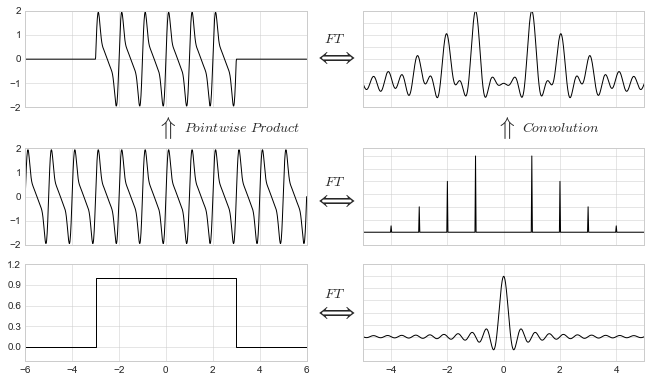

In [4]:
fig, ax = FT_plotgrid(sharey=False)
    

x = np.linspace(-6, 6, 1000)

amplitudes = np.array([1.2, 0.8, 0.4, 0.1])
frequencies = np.array([1, 2, 3, 4])

y = amplitudes @ np.sin(2 * np.pi * frequencies[:, None] * x)

yw = y.copy()
yw[abs(x) > 3] = 0

f = np.linspace(-5, 5, 1000)
y_f = amplitudes @ (np.sinc(4 * (f - frequencies[:, None]))
                    + np.sinc(4 * (f + frequencies[:, None])))

f_delta, y_delta = delta_funcs(np.concatenate([-frequencies, frequencies]),
                               np.concatenate([amplitudes, amplitudes]))

# Upper left panel: The windowed function
ax[0, 0].plot(x, yw, '-k')
for axi in ax[:, 0]:
    axi.yaxis.set_major_locator(plt.MaxNLocator(5))

# Upper right panel: The Fourier Transform
ax[0, 1].plot(f, y_f, '-k')
for axi in ax[:, 1]:
    axi.yaxis.set_major_formatter(plt.NullFormatter())

# Lower left panels: signal and window
ax[1, 0].plot(x, y, '-k')
ax[2, 0].plot(*tophat_func(6, height=1, xmin=-6, xmax=6), '-k')
ax[2, 0].set(ylim=(-0.2, 1.2))

# Lower right panels: signal and window transforms
ax[1, 1].plot(f_delta, y_delta, '-k')
ax[1, 1].set(xlim=(-5, 5),
             ylim=(-0.2, max(amplitudes) * 1.1))

ax[2, 1].plot(f, np.sinc(f * 4), '-k')
ax[2, 1].set(xlim=(-5, 5),
             ylim=(-0.4, 1.2));
    
fig.savefig('fig06_Tophat_Window.pdf')

## Dirac Comb Window

In [5]:
def plot_dirac_comb(T_samp, plot_aliases=False):
    fig, ax = FT_plotgrid(sharey='col')

    sigma_t = 1
    sigma_f = 1. / (2 * np.pi * sigma_t)
    def func(t):
        return np.exp(-0.5 * (t / sigma_t) ** 2)
    def func_FT(f):
        return np.exp(-0.5 * (f / sigma_f) ** 2)

    t = np.linspace(-5, 5, 1000)
    f = np.linspace(-5, 5, 1000)

    t_comb = T_samp * np.arange(-5 // T_samp, 5 // T_samp + 1)
    f_comb = 1. / T_samp * np.arange(-5 // (1. / T_samp), 5. / (1. / T_samp) + 1)

    y_true = func(t)
    yhat_true = func_FT(f)

    # Upper left panel: The windowed function
    ax[0, 0].plot(*delta_funcs(t_comb, func(t_comb)), '-k')
    ax[0, 0].text(0.02, 0.96, r'$\Delta t = {0:.1f}$'.format(T_samp),
                  ha='left', va='top', transform=ax[0, 0].transAxes, size=14)

    # Upper right panel: The Fourier Transform
    if plot_aliases:
        ax[0, 1].plot(f, func_FT(f[:, None] - f_comb), '-k', alpha=0.3)
    ax[0, 1].plot(f, func_FT(f - f_comb[:, None]).sum(0), '-k')

    # Lower left panels: signal and window
    ax[1, 0].plot(t, y_true, '-k')

    ax[2, 0].plot(*delta_funcs(t_comb), '-k')
    ax[2, 0].set(xlim=(-5, 5),
                 ylim=(-0.1, 1.1))

    # Lower right panels: signal and window transforms
    ax[1, 1].plot(f, yhat_true, '-k')

    ax[2, 1].plot(*delta_funcs(f_comb), '-k')
    ax[2, 1].set(xlim=(-5, 5),
                 ylim=(-0.1, 1.1))

    return fig

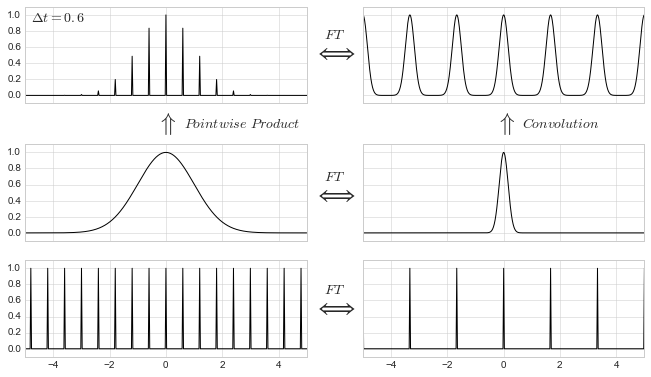

In [6]:
fig = plot_dirac_comb(T_samp=0.6)
fig.savefig('fig07_comb_window_1.pdf')

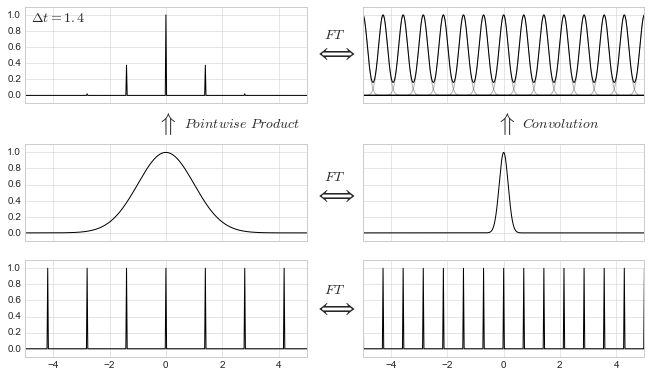

In [7]:
fig = plot_dirac_comb(T_samp=1.4, plot_aliases=True)
fig.savefig('fig08_comb_window_2.pdf')

## Random Observation Times

In [8]:
def plot_random_window(T_samp_avg):
    fig, ax = FT_plotgrid(sharey=False)

    sigma_t = 1
    sigma_f = 1. / (2 * np.pi * sigma_t)
    def func(t):
        return np.exp(-0.5 * (t / sigma_t) ** 2)
    def func_FT(f):
        return np.exp(-0.5 * (f / sigma_f) ** 2)

    t = np.linspace(-5, 5, 1000)
    f = np.linspace(-5, 5, 1000)

    rng = np.random.RandomState(54545)
    t_comb = -5 + 10 * rng.rand(int(np.ceil(10 / T_samp_avg)))

    y_true = func(t)
    yhat_true = func_FT(f)

    ft_comb = np.exp(-2j * np.pi * t_comb[:, None] * f).sum(0)
    yft_comb = np.dot(func(t_comb), np.exp(-2j * np.pi * t_comb[:, None] * f))

    # double-check: this gives the same result (up to edge effects)
    # computed from the convolution of the transforms
    yft_conv = np.convolve(ft_comb, yhat_true, mode='same') / (len(t_comb) * np.sqrt(2 * np.pi))


    # Upper left panel: The windowed function
    ax[0, 0].plot(*delta_funcs(t_comb, func(t_comb)), '-k')
    ax[0, 0].text(0.02, 0.96, r'$avg(\Delta t) = {0:.1f}$'.format(T_samp_avg),
                  ha='left', va='top', transform=ax[0, 0].transAxes, size=14)
    ax[0, 0].set(xlim=(-5, 5),
                 ylim=(-0.1, 1.1))

    # Upper right panel: The Fourier Transform
    ax[0, 1].plot(f, yft_comb.imag, '-', color='gray', label='imag')
    ax[0, 1].plot(f, yft_comb.real, '-k', label='real')

    # Lower left panels: signal and window
    ax[1, 0].plot(t, y_true, '-k')
    ax[1, 0].set(xlim=(-5, 5),
                 ylim=(-0.1, 1.1))

    ax[2, 0].plot(*delta_funcs(t_comb), '-k')
    ax[2, 0].set(xlim=(-5, 5),
                 ylim=(-0.1, 1.1))

    # Lower right panels: signal and window transforms
    ax[1, 1].plot(f, yhat_true, '-k')
    ax[1, 1].set_ylim(-0.1, 1.1)

    ax[2, 1].plot(f, ft_comb.imag, '-', color='gray')
    ax[2, 1].plot(f, ft_comb.real, '-k')
    ax[2, 1].set(xlim=(-5, 5))
    
    return fig

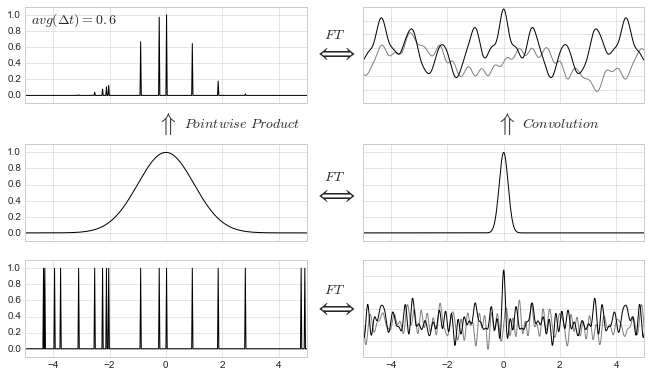

In [9]:
fig = plot_random_window(T_samp_avg=0.6)
fig.savefig('fig10_random_window.pdf')

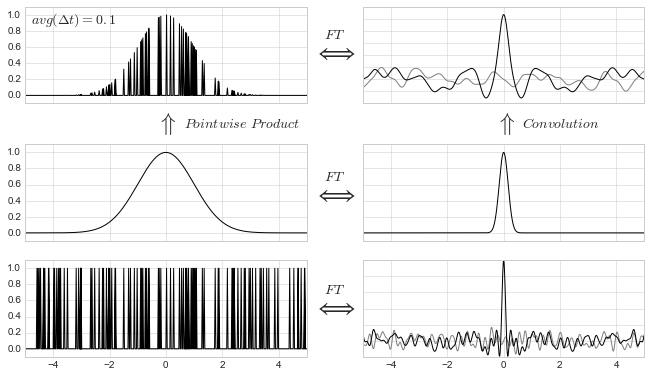

In [10]:
fig = plot_random_window(T_samp_avg=0.1)
fig.savefig('fig11_random_window_2.pdf')